# This notebook is to implement different ways to handle the missing data

In [2]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from xgboost import XGBClassifier

ROOT = '../..'
DATA = os.path.join(ROOT, 'data')
DATA_RAW = os.path.join(DATA, 'raw')
SRC = os.path.join(ROOT, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The only missing data in the datasets is the demographics in the "profile" dataframe.

## Get the initial data (not to be modified)

In [5]:
# Read in the json files
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic preprocessing
data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

In [6]:
print(data.shape)
data.head()

(306534, 20)


,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_email,channel_mobile,channel_social,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
event                   306534 non-null object
person                  306534 non-null object
time                    306534 non-null int64
amount                  138953 non-null float64
offer_id                167581 non-null object
reward                  33579 non-null float64
age                     272762 non-null float64
became_member_on        306534 non-null datetime64[ns]
gender                  272762 non-null object
income                  272762 non-null float64
missing_demographics    306534 non-null int64
member_epoch_days       306534 non-null int64
difficulty              167581 non-null float64
duration                167581 non-null float64
offer_type              167581 non-null object
reward_t                167581 non-null float64
channel_email           167581 non-null float64
channel_mobile          167581 non-null float64
channel_social          167581

In [9]:
data.isnull().mean().sort_values(ascending=False)

reward                  0.890456
amount                  0.546696
channel_web             0.453304
channel_mobile          0.453304
channel_email           0.453304
reward_t                0.453304
offer_type              0.453304
duration                0.453304
difficulty              0.453304
offer_id                0.453304
channel_social          0.453304
age                     0.110174
income                  0.110174
gender                  0.110174
became_member_on        0.000000
missing_demographics    0.000000
member_epoch_days       0.000000
time                    0.000000
person                  0.000000
event                   0.000000
dtype: float64

Almost all the missing data is there because the field doesn't make any sense in the kind of event. The only ones that matter are 'age', 'income' and 'gender'; the 'profile' features.

In [12]:
profile.isnull().mean()

age                     0.127941
became_member_on        0.000000
gender                  0.127941
id                      0.000000
income                  0.127941
missing_demographics    0.000000
member_epoch_days       0.000000
dtype: float64

## Basic filling: Median

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

In [40]:
class BasicImputer(BaseEstimator, TransformerMixin):
    """
    Fills the demographics missing data with medians and most frequent values.
    """
    def __init__(self):
        super(BaseEstimator, self).__init__()
        self.age_value = None
        self.income_value = None
        self.gender_value = None
    
    def fit(self, X, y=None):
        """ Get some medians. """
        self.age_value = X.age.median().round()
        self.income_value = X.income.median()
        self.gender_value = X.gender.mode()
        return self

    def transform(self, X):
        """ Encode offer types and gender """
        return X.fillna({'age': self.age_value,
                         'income': self.income_value,
                         'gender': self.gender_value})

In [41]:
from sklearn.pipeline import Pipeline

In [44]:
transformers = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', BasicImputer())
])

In [45]:
enc = pp.BasicEncoder()
enc.fit(data)

TypeError: '<' not supported between instances of 'str' and 'float'

In [43]:
transformers.fit(data)

TypeError: '<' not supported between instances of 'str' and 'float'

In [36]:
filled = imputer.transform(data)

In [37]:
filled.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_email,channel_mobile,channel_social,channel_web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,55.0,2017-08-04,NaN,62000.0,1,17382,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,55.0,2017-09-25,NaN,62000.0,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,55.0,2017-10-02,NaN,62000.0,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


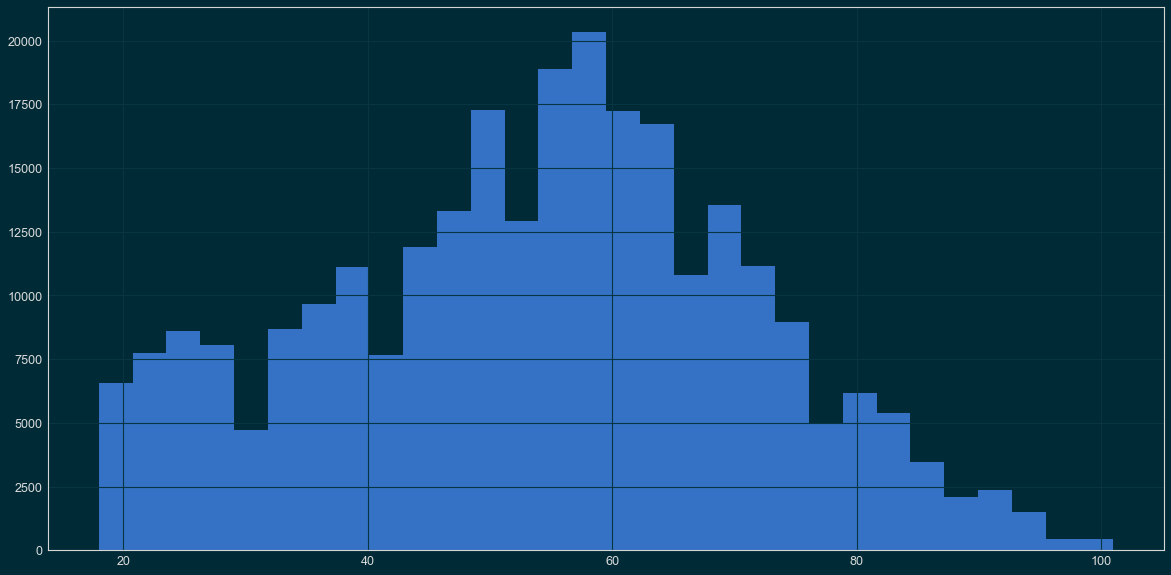

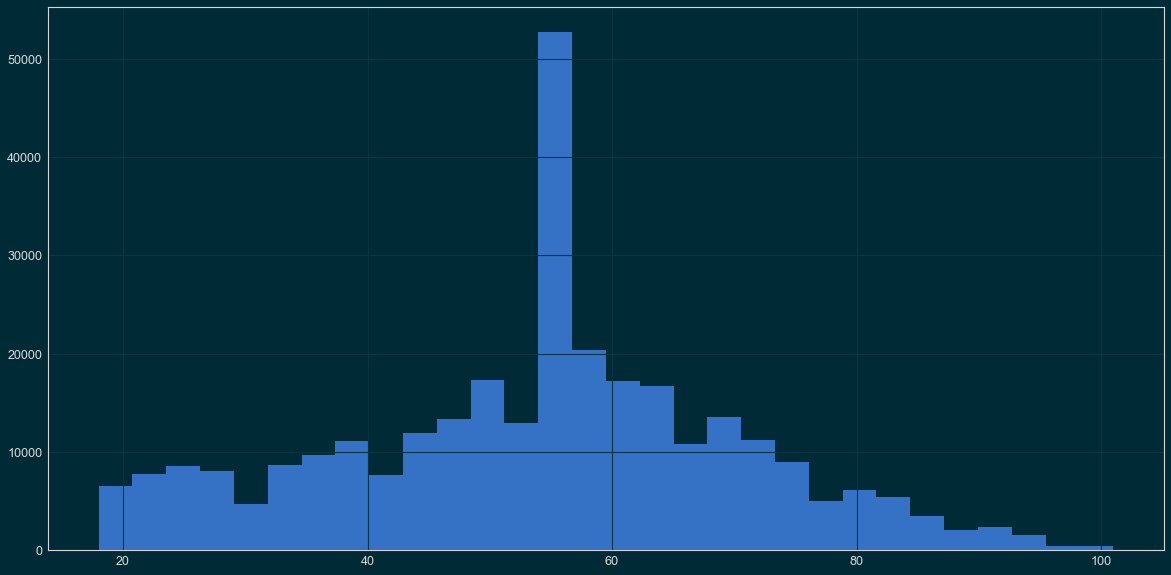

In [29]:
data.age.hist(bins=30)
plt.figure()
filled.age.hist(bins=30)

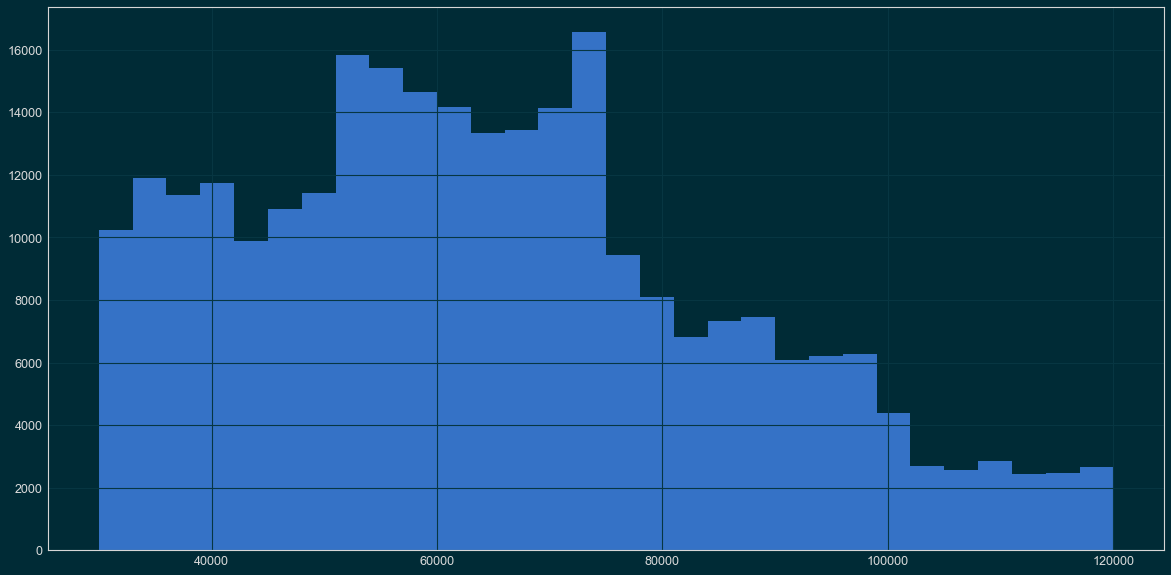

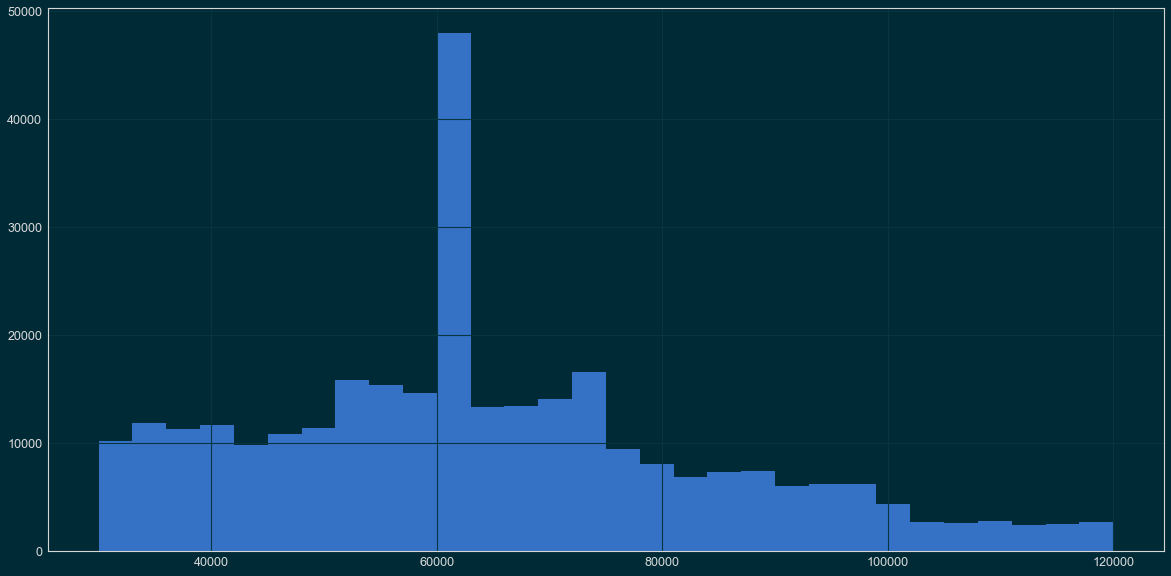

In [30]:
data.income.hist(bins=30)
plt.figure()
filled.income.hist(bins=30)

In [32]:
print(data.gender.value_counts())
print('-'*100)
print(filled.gender.value_counts())

M    155690
F    113101
O      3971
Name: gender, dtype: int64
----------------------------------------------------------------------------------------------------
M    155690
F    113101
O      3971
Name: gender, dtype: int64


In [39]:
data.gender.fillna(data.gender.mode())

0           F
1         NaN
2           M
3         NaN
4         NaN
5           M
6         NaN
7           M
8           F
9           F
10        NaN
11        NaN
12          M
13          F
14          F
15          M
16          F
17        NaN
18          M
19          M
20          F
21          M
22          F
23        NaN
24          F
25        NaN
26          M
27          F
28          M
29        NaN
         ... 
306504      M
306505    NaN
306506    NaN
306507      F
306508      M
306509      M
306510      F
306511      M
306512      M
306513      M
306514      M
306515      F
306516      F
306517      M
306518      F
306519      M
306520      M
306521      M
306522      M
306523      M
306524      F
306525      M
306526      F
306527      F
306528    NaN
306529      M
306530      M
306531      F
306532      M
306533    NaN
Name: gender, Length: 306534, dtype: object